In [5]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

from scipy.spatial import distance

In [87]:
# define class object for each string element
class Element:
    # define element ID
    def __init__(self, number, total):  
        self.number = number # number starts from 0
        self.number_total = total
        self.weight = 1/total
        self.youngs_modulus = 40
        self.original_length = 1.0/(total-1) # length of segment
        self.position = np.array([self.original_length * number, 0.0])
        self.velocity = np.array([0.0, 0.0])
        self.force_tensile_left = np.array([0.0, 0.0])
        self.force_tensile_right = np.array([0.0, 0.0])
        self.force_external = np.array([0.0, 0.0])
        self.friction_coeff = 1.0
        self.friction_min = 0.0001
    # set external force, could be per element (catenary) or distributed (suspension bridge)
    def set_external_force(self, force):
        self.force_external = [0, force]
    # force set velocity to satisfy Boundary Conditions
    def set_velocity_x(self, velocity):
        self.velocity[0] = velocity
    def set_velocity_y(self, velocity):
        self.velocity[1] = velocity
    # calculate tensile force
    def calc_tensile_force(self, neighbor):
        length = distance.euclidean(self.position, neighbor.position)
        vector = (neighbor.position - self.position)/length
        force_scalar = (length/self.original_length - 1.0)*self.youngs_modulus
        force_tensile = force_scalar * vector
        return force_tensile
    # calculate tensile force left
    def calc_tensile_force_left(self, neighbor_left):
        self.force_tensile_left = self.calc_tensile_force(neighbor_left)
    # calculate tensile force right
    def calc_tensile_force_right(self, neighbor_right):
        self.force_tensile_right = self.calc_tensile_force(neighbor_right)
    # calculate velocity
    def calc_velocity(self, dt):
        self.velocity = self.velocity + dt * (self.force_tensile_left + self.force_tensile_right + self.force_external) / self.weight
    # calculate new position
    def calc_position(self, dt):
        self.position = self.position + dt * self.velocity
    # deminish velocity
    def diminish_velocity(self, dt):
        mag = np.sqrt(self.velocity.dot(self.velocity))
        if mag < self.friction_min:
            self.velocity  = np.array([0.0, 0.0])
        else:
            self.velocity = self.velocity - self.velocity * self.friction_coeff * dt
            

In [72]:

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    print(f"Processing step {i}", end="\r", flush=True)
    for j in range(total):
        obj = elements[j]
        # calculate force
        if 0==j:
            obj.calc_tensile_force_right(elements[j+1])
        elif total-1==j:
            obj.calc_tensile_force_left(elements[j-1])
        else:
            obj.calc_tensile_force_left(elements[j+1])
            obj.calc_tensile_force_right(elements[j-1])
        obj.calc_velocity(dt)
        # force boundary conditions
        if 0==j:
            obj.set_velocity_x(0)
            #print(obj.velocity[1])
        elif total-1==j:
            obj.set_velocity_x(0)
            obj.set_velocity_y(0)
        else:
            pass
    # calculate and update new position, MUST be separate loop from calculation of force
    thisx = []
    thisy = []
    for j in range(total):
        obj = elements[j]
        obj.calc_position(dt)
        # testing
#         if 1==j:
#             print(obj.position)
        thisx.append(obj.position[0])
        thisy.append(obj.position[1])
        # diminish velocity to simulate internal dissipation
        obj.diminish_velocity(dt)
    
    # ready for animation
    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text


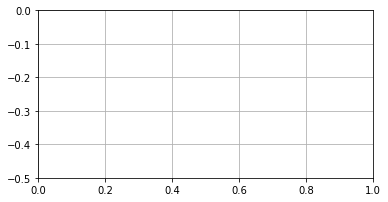

In [88]:

# initialize
total = 11 # total number of elements
elements = [] # initial list of elements
force = -1.0 # total distributed force

# set loop parameters
dt = 0.01 # timestep
steps = 1500

# create elements
for i in range(total):
    elements.append(Element(i, total))

# set distributed force
for obj in elements:
    obj.set_external_force(force/total)


# set figure
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, 1), ylim=(-0.5, 0))
ax.set_aspect("equal")
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

ani = animation.FuncAnimation(fig, animate, range(steps),
                              interval=dt*1000, blit=True, init_func=init)
plt.show()


In [89]:
from IPython.display import HTML
HTML(ani.to_html5_video())

In [ ]:

# # loop over timesteps
# for t in np.arange(0, 100, dt):
#     # calculate force
#     for j in range(total):
#         obj = elements[j]
#         if 0==j:
#             obj.calc_tensile_force_right(elements[j+1])
#         elif total-1==j:
#             obj.calc_tensile_force_left(elements[j-1])
#         else:
#             obj.calc_tensile_force_left(elements[j+1])
#             obj.calc_tensile_force_right(elements[j-1])
#     # calculate velocity
#     for j in range(total):
#         obj = elements[j]
#         obj.calc_velocity(dt)
#         # force boundary conditions
#         if 0==j:
#             obj.set_velocity_x(0)
#         elif total-1==j:
#             obj.set_velocity_x(0)
#             obj.set_velocity_y(0)
#         else:
#             pass
#     # calculate new position
#     for j in range(total):
#         obj = elements[j]
#         obj.calc_position(dt)
#         # testing
#         if 1==j:
#             print(obj.position)
    